In [1]:
import pandas as pd
import numpy as np
import os
import netCDF4 as nc  
import matplotlib.pyplot as plt
import plotly.express as px
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from ripser import Rips
rips = Rips(maxdim=1)
import pickle
from tqdm import tqdm
from datetime import datetime
import scipy.io
import seaborn as sns

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [2]:
# Get the path of the notebook file
notebook_path = os.path.abspath('__file__')

# Directory containing the notebook file
notebook_directory = os.path.dirname(notebook_path)

# Loading the data

In [3]:
dSet_SL = nc.Dataset(notebook_directory+"/Data/slp.daily.nc")
# Extract variables from the dataset
# This example assumes there are time, lat, lon, and a variable 'hgt'
time = dSet_SL.variables['time'][:]
lat = dSet_SL.variables['lat'][:]
lon = dSet_SL.variables['lon'][:]
slp = dSet_SL.variables['slp'][:]

In [4]:
lat_cut = [[22.5,70]]
lon_cut = [[280,360],[0,50]]

In [5]:
# Function to check if a value is within any of the specified ranges
def is_in_ranges(value, ranges):
    for r in ranges:
        if r[0] <= value <= r[1]:
            return True
    return False

In [6]:
def give_index(list,list_cut):
    indices = []
    for i in range(len(list.data)):
        if is_in_ranges(list.data[i],list_cut):
            indices.append(i)
    return indices

lon_index = give_index(lon,lon_cut)
lat_index = give_index(lat,lat_cut)

In [7]:
slp_new = slp[:,lat_index,:][:,:,lon_index]

In [8]:
slp.data.shape

(27919, 73, 144)

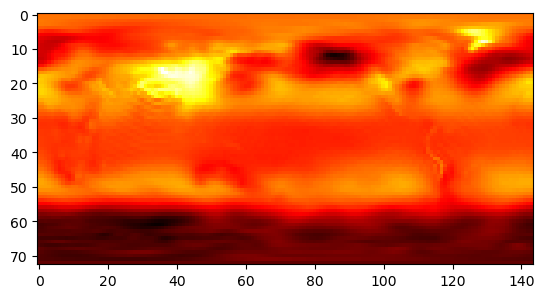

In [9]:
plt.imshow(slp[0].data, cmap='hot')
plt.show()

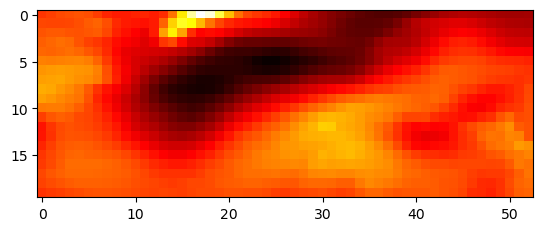

In [10]:
plt.imshow(np.hstack((slp_new[0][:, 21:], slp_new[0][:, 0:21])).data, cmap='hot')
plt.show()

## Flattening the HGT

In [11]:
slp_list = []
for i in range(len(slp_new)):
    slp_list.append(np.array(np.hstack((slp_new[i][:, 21:], slp_new[i][:, 0:21])).data.flatten()))

# Normalizing the data

In [12]:
start_year = 1948 

In [13]:
def del_29_Feb(reading_list,start_year):
    step = 0
    while start_year + step < 2024:
        if (start_year+step)%4 == 0:
            del reading_list[step*365+59]
        step += 1
    return reading_list[:step*365]

In [14]:
slp_list = del_29_Feb(slp_list,1948)

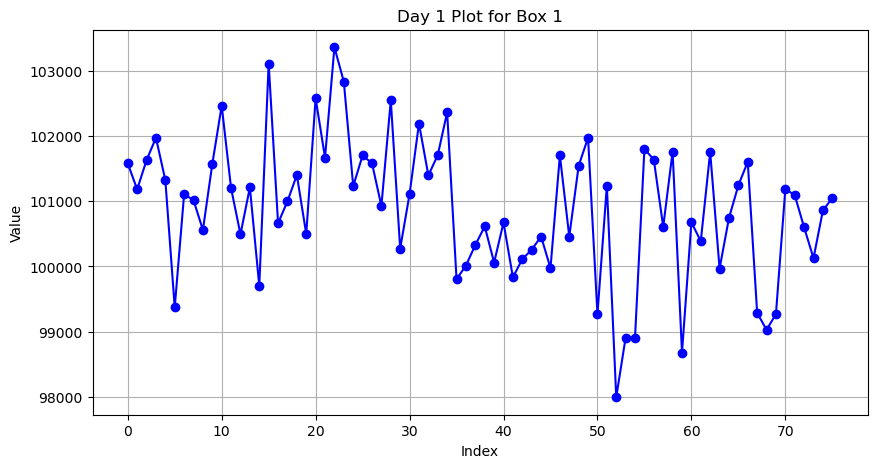

In [15]:
day_1 = []
for i in range(76):
    day_1.append(slp_list[i*365][0])
    
# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(day_1, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Day 1 Plot for Box 1')
plt.xlabel('Index')
plt.ylabel('Value')

# Show grid
plt.grid(True)

# Display the plot
plt.show()

In [16]:
def av_day(reading_list):
    num_year = int(len(reading_list)/365)
    av_list = reading_list[:365]

    for i in range(1,num_year):
        for j in range(365):
            av_list[j] = av_list[j] + reading_list[i*365+j]
    
    for i in range(len(av_list)):
        av_list[i] = av_list[i]*1/num_year
    
    for i in range(num_year):
        for j in range(365):
            reading_list[i*365+j] = reading_list[i*365+j] - av_list[j]

    return reading_list

In [17]:
slp_list = av_day(slp_list)

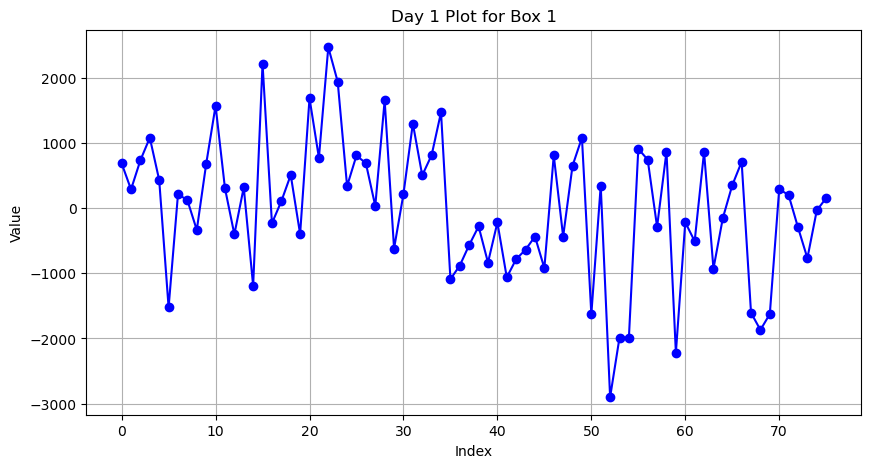

In [18]:
day_1 = []
for i in range(76):
    day_1.append(slp_list[i*365][0])
    
# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(day_1, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Day 1 Plot for Box 1')
plt.xlabel('Index')
plt.ylabel('Value')

# Show grid
plt.grid(True)

# Display the plot
plt.show()

In [19]:
len(lon_index[:21]),len(lon_index[21:])

(21, 32)

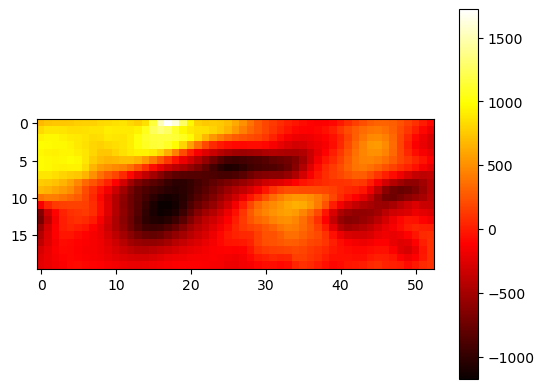

In [20]:
plt.imshow(slp_list[0].reshape((len(lat_index), len(lon_index))), cmap='hot')
plt.colorbar()
plt.show()

In [21]:
slp_2023 = slp_list[-365:]

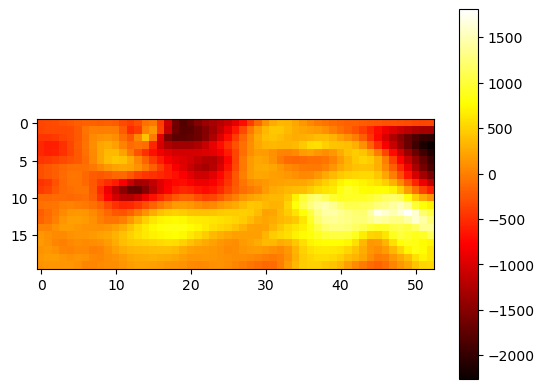

In [22]:
plt.imshow(slp_2023[1].reshape((len(lat_index), len(lon_index))), cmap='hot')
plt.colorbar()
plt.show()

## Plotting on Globe

In [23]:
lon_cut[0][0],lon_cut[1][1]

(280, 50)

In [24]:
def plot_on_globe(reading_list, std_scaling=False, std_scale=2.0):
    """
    Plot data on a globe with flexible color scaling options.
    
    Parameters:
    reading_list: array of data values
    std_scaling: if True, use standard deviation scaling; if False, use absolute max (default: False)
    std_scale: number of standard deviations to use for color scaling when std_scaling=True (default: 2.0)
    """
    # Generate latitude and longitude arrays
    lat = np.linspace(lat_cut[0][0], lat_cut[0][1], reading_list.reshape((len(lat_index), len(lon_index))).shape[0])
    lon = np.linspace(-80, 50, reading_list.reshape((len(lat_index), len(lon_index))).shape[1])
    lon, lat = np.meshgrid(lon, lat)

    # Calculate the center of the specified lat/lon ranges
    central_lat = np.mean(lat_cut[0])
    central_lon = np.mean(-15)

    # Create a figure and add an Orthographic projection centered at the calculated lat/lon
    fig = plt.figure(figsize=(12, 10))  # Slightly larger figure for better spacing
    ax = plt.axes(projection=ccrs.Orthographic(central_longitude=central_lon, central_latitude=central_lat))

    # Add features like coastlines, countries, and gridlines
    ax.add_feature(cfeature.COASTLINE, linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linewidth=1.0)
    
    # Add gridlines with larger font
    gl = ax.gridlines(draw_labels=True, linewidth=0.8, color='gray', alpha=0.5, linestyle='--')
    if hasattr(gl, 'xlabel_style'):
        gl.xlabel_style = {'size': 12, 'color': 'black'}
        gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    # Get the data for plotting
    data = reading_list.reshape((len(lat_index), len(lon_index)))
    
    # Determine color scale based on parameter
    if std_scaling:
        # Standard deviation scaling
        std_dev = np.std(data)
        vmax = std_scale * std_dev
    else:
        # Original absolute maximum scaling
        vmax = np.max(np.abs(data))
    
    # Plot the matrix data on the globe with a red-blue colormap centered at 0
    cs = ax.pcolormesh(lon, lat, data, 
                       cmap='RdBu_r',  # RdBu_r: red for positive, blue for negative
                       vmin=-vmax, 
                       vmax=vmax,
                       transform=ccrs.PlateCarree())

    # Add a colorbar with increased spacing and larger font
    cbar = plt.colorbar(cs, orientation='vertical', pad=0.08, aspect=40, shrink=0.8)
    cbar.ax.tick_params(labelsize=12)  # Increase colorbar tick font size
    cbar.set_label('Pressure (Pa)', size=14)  # Add units label to colorbar
    
    plt.tight_layout()
    return plt

In [38]:
def create_standalone_colorbar(reading_list, std_scaling=False, std_scale=2.0, 
                              label='Pressure (Pa)', label_fontsize=14, tick_fontsize=12,
                              cmap='RdBu_r', figsize=(2, 4)):
    """
    Create a standalone colorbar figure with no plot.
    
    Parameters:
    reading_list: array of data values
    std_scaling: if True, use standard deviation scaling; if False, use absolute max
    std_scale: number of standard deviations for color scaling when std_scaling=True
    label: Label for the colorbar
    label_fontsize: Font size for the colorbar label
    tick_fontsize: Font size for the colorbar tick labels
    cmap: Colormap to use
    figsize: Figure size (width, height)
    
    Returns:
    fig: The figure object containing only the colorbar
    """
    # Get the data for scaling calculations
    data = reading_list.reshape((len(lat_index), len(lon_index)))
    
    # Determine color scale
    if std_scaling:
        std_dev = np.std(data)
        vmax = std_scale * std_dev
    else:
        vmax = np.max(np.abs(data))
    
    # Create figure and axis for colorbar only
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0.1, 0.1, 0.3, 0.8])  # [left, bottom, width, height]
    
    # Create a ScalarMappable for the colorbar
    from matplotlib.cm import ScalarMappable
    from matplotlib.colors import Normalize
    
    norm = Normalize(vmin=-vmax, vmax=vmax)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    
    # Create the colorbar
    cbar = plt.colorbar(sm, cax=ax)
    cbar.ax.tick_params(labelsize=tick_fontsize)
    cbar.set_label(label, size=label_fontsize)
    
    return fig

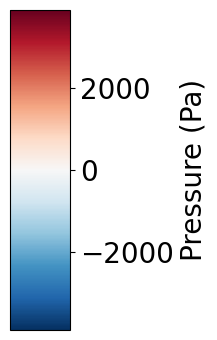

In [39]:
n=314
create_standalone_colorbar(slp_2023[n],tick_fontsize=20,label_fontsize=20)
plt.savefig(notebook_directory+"/figures/global_projection_color_bar.png", dpi=500, bbox_inches='tight')  # PNG format
plt.show()

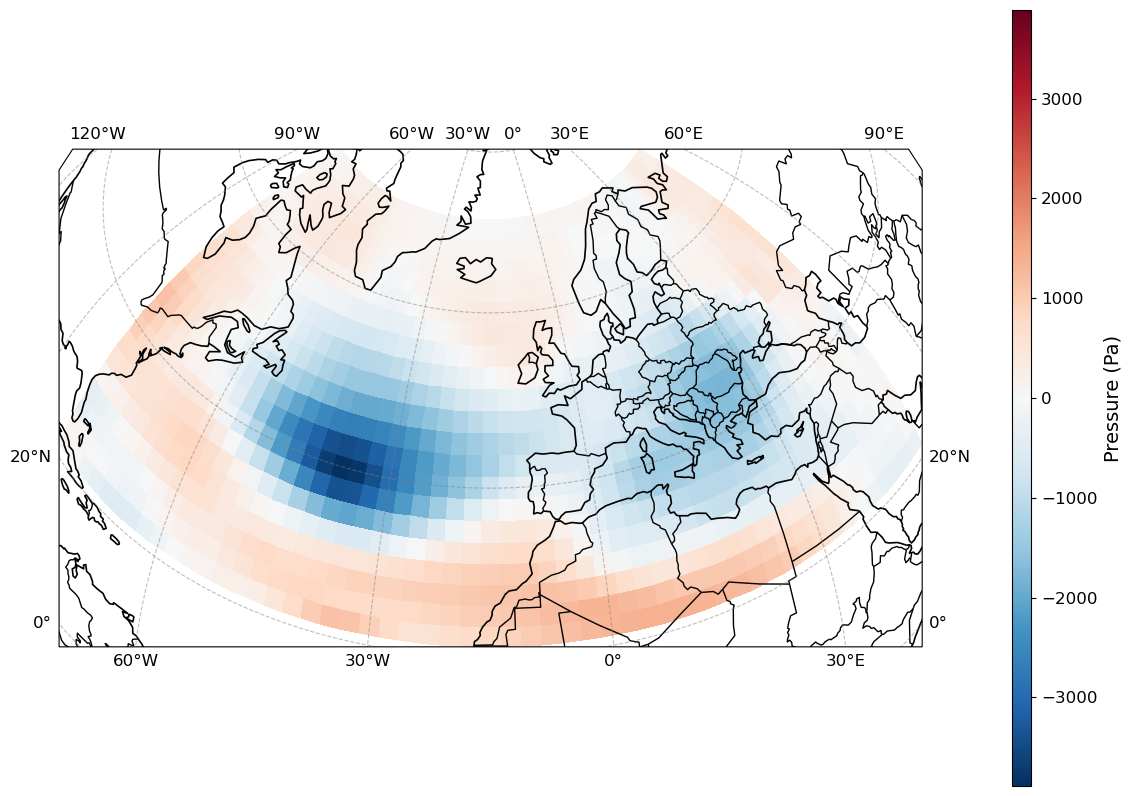

In [25]:
n=314
plot_on_globe(slp_2023[n])
#plt.savefig(notebook_directory+"/figures/global_projection.png", dpi=500, bbox_inches='tight')  # PNG format
plt.show()

# Cubical Persistence T-construction for Positive Region

In [26]:
import tcripser as tcr

def get_diagram(P, d):
  return P[(P[:, 2]<1e100) & (P[:, 0]==d)][:, 1:3]

def plot_cubical_ripser_diagram(P,dim_list = [0,1]):
  for d in dim_list:
    PD = get_diagram(P, d)
    plt.scatter(*PD.T, label=d, alpha=1)
    plt.axis('equal') 
  plt.legend()
  return PD

In [27]:
def get_fun(X):
    def show_thr(t):
        plt.figure(figsize=(10, 8))
        
        # Create a mask based on the threshold
        mask = X <= t
        
        # Use a custom blue-red colormap
        colors = ['white', 'gray']
        custom_cmap = plt.matplotlib.colors.ListedColormap(colors)
        
        img = plt.imshow(mask, cmap=custom_cmap)

        font = 50
        #plt.title(f"Threshold: {-t}", fontsize=font)
        print()
        
        # Remove ticks from both axes
        plt.tick_params(axis='both', which='both', bottom=False, top=False, 
                      left=False, right=False, labelbottom=False, labelleft=False)
        
        # Add grid for better reference
        plt.grid(False)
        
        plt.tight_layout()
        plt.show()
        
    return show_thr

In [28]:
from ipywidgets import interact, IntSlider

# def get_fun(X):
#   def show_thr(t):
#     plt.imshow(X <= t, cmap='gray')
#     plt.title(f"Threshold: {t}")
#     # Adding labels and legend
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')
#     plt.show()
#   return show_thr

def vis(X, v=0):
  slider = IntSlider(value=v, min=X.min(), max=X.max(), step=1, description="thr")
  interact(get_fun(X), t=slider)

In [29]:
def plot_points(points_array, fontsize=12):
    """
    Plot an array of 2D points with the x=y line
    
    Parameters:
    points_array : numpy array or list of [x, y] coordinates
    fontsize : int, optional, default=12, controls the size of text elements
    """
    # Convert to numpy array if not already
    points = np.array(points_array)
    
    # Extract x and y coordinates
    x = points[:, 0]
    y = points[:, 1]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Find min and max across both axes to ensure consistency
    min_val = min(np.min(x), np.min(y))
    max_val = max(np.max(x), np.max(y))
    
    # Add a small margin for better visualization
    margin = (max_val - min_val) * 0.05
    plot_min = min_val - margin
    plot_max = max_val + margin
    
    # Plot x=y line
    diagonal = np.linspace(plot_min, plot_max, 100)
    ax.plot(diagonal, diagonal, 'k-', linewidth=1.5, alpha=0.7)
    
    # Plot points
    ax.scatter(x, y, color='black', s=100)
    
    # Set equal limits for both axes
    ax.set_xlim(plot_min, plot_max)
    ax.set_ylim(plot_min, plot_max)
    
    # Create equal tick positions for both axes
    ticks = np.linspace(plot_min, plot_max, 5)  # 5 ticks from min to max
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    
    # Add labels
    ax.set_xlabel('Birth', fontsize=fontsize)
    ax.set_ylabel('Death', fontsize=fontsize)
    
    # Increase font size of tick labels
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    
    # Equal aspect ratio for better visualization
    ax.set_aspect('equal')
    
    plt.tight_layout()
    return plt

In [30]:
def get_fun(X):
    def show_thr(t):
        plt.figure(figsize=(10, 8))
        
        # Create a mask based on the threshold
        mask = X <= t
        
        # Generate latitude and longitude arrays (from globe function)
        lat = np.linspace(lat_cut[0][0], lat_cut[0][1], mask.reshape((len(lat_index), len(lon_index))).shape[0])
        lon = np.linspace(-80, 50, mask.reshape((len(lat_index), len(lon_index))).shape[1])
        lon, lat = np.meshgrid(lon, lat)
        
        # Calculate the center of the specified lat/lon ranges
        central_lat = np.mean(lat_cut[0])
        central_lon = np.mean(-15)
        
        # Create globe projection
        ax = plt.axes(projection=ccrs.Orthographic(central_longitude=central_lon, central_latitude=central_lat))
        
        # Add features like coastlines and countries (no gridlines as requested)
        ax.add_feature(cfeature.COASTLINE, linewidth=1.2)
        ax.add_feature(cfeature.BORDERS, linewidth=1.0)
        
        # Get the data for plotting
        data = mask.reshape((len(lat_index), len(lon_index)))
        
        # Use a custom blue-red colormap
        colors = ['white', 'gray']
        custom_cmap = plt.matplotlib.colors.ListedColormap(colors)
        
        # Plot the matrix data on the globe
        cs = ax.pcolormesh(lon, lat, data.astype(float), 
                           cmap=custom_cmap,
                           transform=ccrs.PlateCarree())
        
        plt.tight_layout()
        plt.show()
        
    return show_thr

In [31]:
X = slp_2023[n].reshape((len(lat_index), len(lon_index)))
# vis(-X)

5102.671875

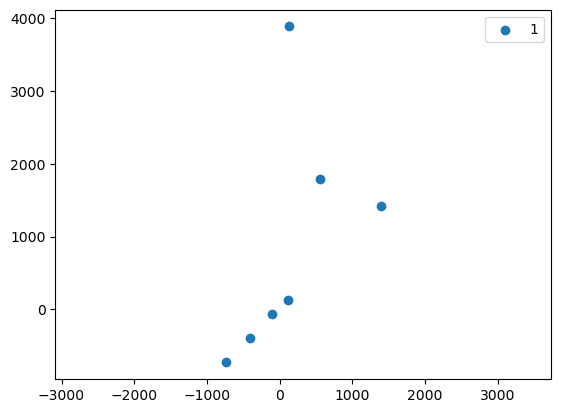

In [32]:
P = tcr.computePH(-X)
pdiag = plot_cubical_ripser_diagram(P,dim_list=[1])
sum(pdiag[:,1]-pdiag[:,0])

In [33]:
# # Example usage:
# plot_points(-pd, fontsize=28)
# #plt.savefig(notebook_directory+"/figures/pd_cub_dec.png", dpi=500, bbox_inches='tight')  # PNG format
# plt.show()

In [34]:
vis(X)

interactive(children=(IntSlider(value=0, description='thr', max=1375, min=-3889), Output()), _dom_classes=('wi…

1204.6796875

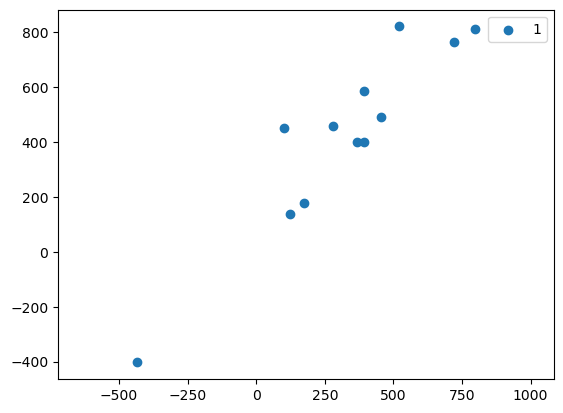

In [35]:
P = tcr.computePH(X)
pdiag = plot_cubical_ripser_diagram(P,dim_list=[1])
sum(pdiag[:,1]-pdiag[:,0])

In [36]:
# # Example usage:
# plot_points(pd, fontsize=28)
# plt.savefig(notebook_directory+"/figures/pd_cub_inc.png", dpi=500, bbox_inches='tight')  # PNG format
# plt.show()

# Persistences for year (2023-1948)

# Generating persistence

In [37]:
# persistences_positive = {}
# persistences_negative = {}

# for j in tqdm(range(2024-1948)):
#     slp_cut = slp_list[j*365:(j+1)*365]
#     persistences_positive_year = []
#     persistences_negative_year = []

#     for i in range(365):
#         X = slp_cut[i].reshape((len(lat_index), len(lon_index)))

#         P = tcr.computePH(-X)
#         persistences_positive_year.append(P[P[:,0]==1][:,1:3][:,1]-P[P[:,0]==1][:,1:3][:,0])

#         P = tcr.computePH(X)
#         persistences_negative_year.append(P[P[:,0]==1][:,1:3][:,1]-P[P[:,0]==1][:,1:3][:,0])

#     persistences_positive[j+1948] = persistences_positive_year
#     persistences_negative[j+1948] = persistences_negative_year

In [38]:
# # Save the dictionary to a pickle file
# with open(notebook_directory+'/Data/persistences_posititve_CR.pkl', 'wb') as file:
#     pickle.dump(persistences_positive, file)

# # Save the dictionary to a pickle file
# with open(notebook_directory+'/Data/persistences_negative_CR.pkl', 'wb') as file:
#     pickle.dump(persistences_negative, file)

In [39]:
# Load the dictionary from the pickle file
with open(notebook_directory+'/Data/persistences_posititve_CR.pkl', 'rb') as file:
    loaded_persistences_positive = pickle.load(file)

# Load the dictionary from the pickle file
with open(notebook_directory+'/Data/persistences_negative_CR.pkl', 'rb') as file:
    loaded_persistences_negative = pickle.load(file)

# Analysis

## Load persistence information for Cubical Persistence of Positive and Negative regions of SLP-anomaly

In [40]:
# Load the dictionary from the pickle file
with open(notebook_directory+'/Data/persistences_posititve_CR.pkl', 'rb') as file:
    loaded_persistences_positive = pickle.load(file)

# Load the dictionary from the pickle file
with open(notebook_directory+'/Data/persistences_negative_CR.pkl', 'rb') as file:
    loaded_persistences_negative = pickle.load(file)

In [41]:
# Function to calculate means of the inner lists
def calculate_sums(nested_list):
    return [np.sum(sublist) for sublist in nested_list]

def find_anomalies_per(df_column):
    # Convert the Series of lists to a 2D numpy array
    # Each row represents a year, each column represents the same day across years
    data_array = np.array(df_column.tolist())

    # Calculate the average for each day across all years
    daily_averages = np.mean(data_array, axis=0)

    # Subtract the daily average from each corresponding day
    anomalies = data_array - daily_averages

    # Convert back to list of lists format
    return [list(year_data) for year_data in anomalies]

In [42]:
# Convert dictionary to DataFrame
per_pos_df = pd.DataFrame(list(loaded_persistences_positive.items()), columns=['Year', 'Persistences'])
# Apply the function to each element in the 'Persistences' column to create the new 'Means' column
per_pos_df['total_persistence'] = per_pos_df['Persistences'].apply(calculate_sums)
per_pos_df["anomaly_total_per"] = find_anomalies_per(per_pos_df.total_persistence)

In [43]:
# Convert dictionary to DataFrame
per_neg_df = pd.DataFrame(list(loaded_persistences_negative.items()), columns=['Year', 'Persistences'])
# Apply the function to each element in the 'Persistences' column to create the new 'Means' column
per_neg_df['total_persistence'] = per_neg_df['Persistences'].apply(calculate_sums)
per_neg_df["anomaly_total_per"] = find_anomalies_per(per_neg_df.total_persistence)

### Slicing df to match time for other climate indices

In [44]:
num_of_years = 2022 - 1950 + 1
num_of_days = num_of_years * 365
num_of_years, num_of_days

(73, 26645)

In [45]:
per_pos_df = per_pos_df[2:75]
per_neg_df = per_neg_df[2:75]
pos_anomaly_total_per_list = np.array(per_pos_df.anomaly_total_per.to_list()).flatten()
neg_anomaly_total_per_list = np.array(per_neg_df.anomaly_total_per.to_list()).flatten()

## Loading climate indices

### Daily climate indices

In [46]:
# entry from 1 Jan 1950 to 31 Dec 2024
mat_indices = scipy.io.loadmat(notebook_directory+'/Data/Several_Atmospheric_Indices_since1950.mat')

In [47]:
# Extract the arrays from mat_indices
dates = mat_indices['Dates_all'][0][:num_of_days]  # Remove the extra dimension
amo = mat_indices['AMO_daily'][0][:num_of_days] 
ea = mat_indices['EA_daily_detrend'][0][:num_of_days] 
enso = mat_indices['ENSO_daily'][0][:num_of_days] 
nao = mat_indices['NAO_daily'][0][:num_of_days] 
pdo = mat_indices['PDO_daily'][0][:num_of_days] 
scand = mat_indices['SCAND_daily'][0][:num_of_days] 

In [48]:
# Convert date integers to datetime objects
datetime_dates = []
for date_int in dates:
    year = int(date_int // 10000)
    month = int((date_int % 10000) // 100)
    day = int(date_int % 100)
    datetime_dates.append(datetime(year, month, day))

In [49]:
# Create DataFrame
indices_df_daily = pd.DataFrame({
    'Date': datetime_dates,
    'AMO': amo,
    'EA': ea,
    'ENSO': enso,
    'NAO': nao,
    'PDO': pdo,
    'SCAND': scand,
    'pos_total_per_anomaly': pos_anomaly_total_per_list,
    'neg_total_per_anomaly': neg_anomaly_total_per_list
})

# Set the 'Date' column as the index
indices_df_daily.set_index('Date', inplace=True)

### Monthly climate indices

In [50]:
# Resample to monthly frequency
monthly_df = indices_df_daily[['AMO', 'EA', 'ENSO', 'NAO', 'PDO', 'SCAND','pos_total_per_anomaly', 'neg_total_per_anomaly']].resample('MS').mean()

## Analysis of Monthly climate indices

In [63]:
def plot_column(df, column_name, figsize=(12, 6), label_fontsize=12, tick_fontsize=10,diff = False):
    """
    Create a simple black and white plot of a specified column from a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data with a DatetimeIndex
    column_name : str
        The name of the column to plot
    figsize : tuple, optional
        The figure size (width, height) in inches
    label_fontsize : int, optional
        Font size for the axis labels
    tick_fontsize : int, optional
        Font size for the tick labels
    
    Returns:
    --------
    The matplotlib plot object ready for display
    """
    
    # Create figure and axis
    plt.figure(figsize=figsize)
    
    # Plot the data with a simple black line
    plt.plot(df.index, df[column_name], color='black', linewidth=1.5)
    
    plt.xlabel("Year", fontsize=label_fontsize)
    if diff:
        plt.ylabel("Monthly TP anomaly", fontsize=label_fontsize)
    else:
        plt.ylabel(column_name, fontsize=label_fontsize)
    
    # Increase tick label font size
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    
    # Remove grid
    plt.grid(False)
    # Format the date axis
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    return plt

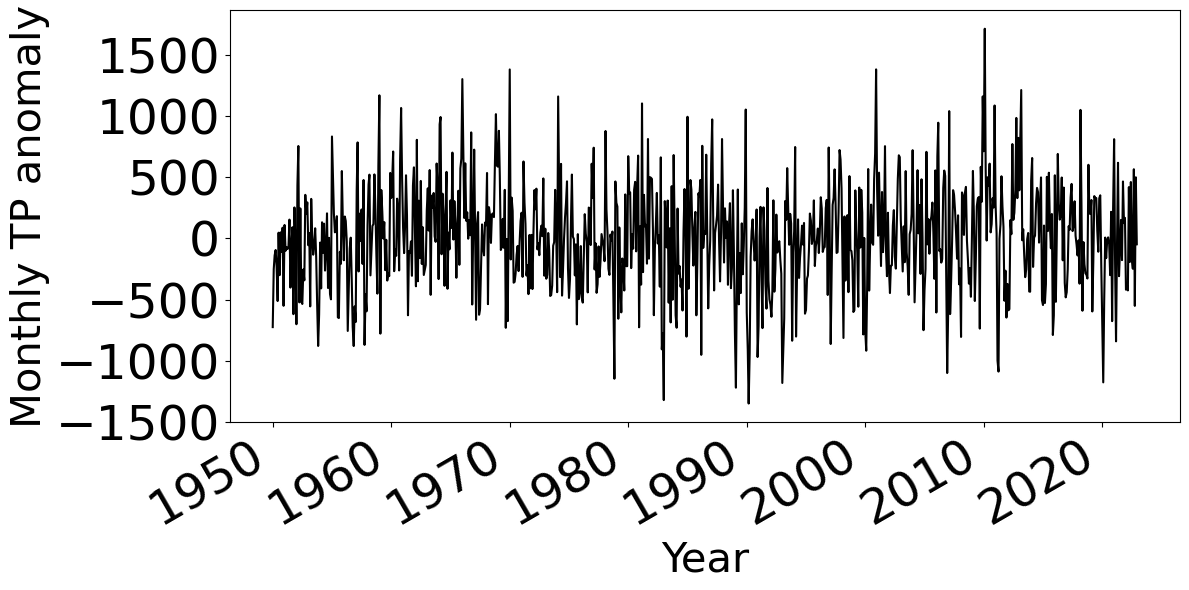

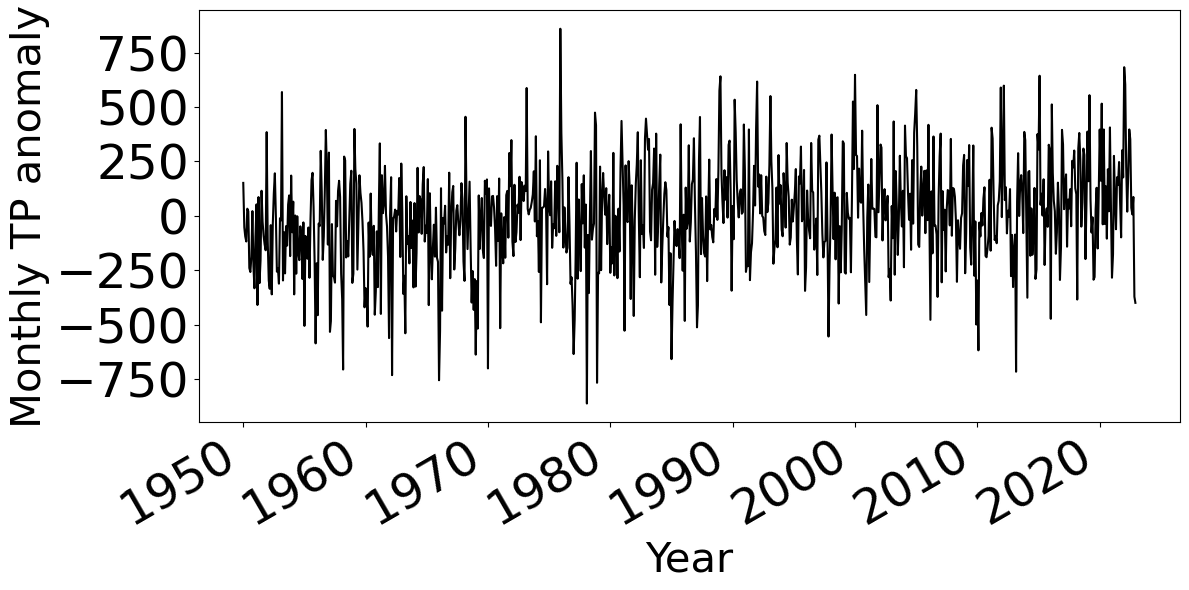

In [70]:
for col in ['pos_total_per_anomaly','neg_total_per_anomaly']:
    plot_column(monthly_df,col,label_fontsize=30,tick_fontsize=35,diff=True)
    plt.savefig(notebook_directory+"/figures/monthly_charts/"+col+"_monthly_chart.png", dpi=500, bbox_inches='tight')  # PNG format
    plt.show()

In [111]:
# for col in ['AMO', 'EA', 'ENSO', 'NAO', 'PDO', 'SCAND']:
#     plot_column(monthly_df,col,label_fontsize=35,tick_fontsize=35)
#     plt.savefig(notebook_directory+"/figures/monthly_charts/"+col+"_monthly_chart.png", dpi=500, bbox_inches='tight')  # PNG format
#     #plt.show()